### Imports

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import trainer_lib as tl

torch.manual_seed(2412231200)
random.seed(3009231410)
np.random.seed(2909231846)
np_random_state = np.random.RandomState(131002)

### Load data

In [2]:
df: pd.DataFrame = tl.load_country_wide_dataset('../data/country_data.csv')

X = df['el_load'].to_numpy(dtype=np.float32)
y = X.copy()

### Define models

In [39]:
class ConvNetSmall(nn.Module):
    def __init__(self, dropout=0.5, **kwargs):
        super(ConvNetSmall, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 8, 5, padding=2),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(8, 16, 5, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(1, -1),
            nn.Dropout(dropout),
            nn.Linear(6 * 16, 3),
        )

    def forward(self, x):
        x = x.reshape(-1, 1, 24)
        x = self.conv(x)
        x = self.fc(x)
        return x
    
class ConvNetMedium(nn.Module):
    def __init__(self, dropout=0.5, **kwargs):
        super(ConvNetMedium, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, 7, padding=3),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout / 5),
            nn.Conv1d(16, 32, 7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout / 5),
            nn.Conv1d(32, 32, 7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(1, -1),
            nn.Dropout(dropout),
            nn.Linear(3 * 32, 3),
        )

    def forward(self, x):
        x = x.reshape(-1, 1, 24)
        x = self.conv(x)
        x = self.fc(x)
        return x
    
class ConvNetLarge(nn.Module):
    def __init__(self, dropout=0.5, **kwargs):
        super(ConvNetLarge, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, 9, padding=4),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout / 5),
            nn.Conv1d(32, 64, 9, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout / 5),
            nn.Conv1d(64, 64, 9, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(1, -1),
            nn.Dropout(dropout / 2),
            nn.Linear(3 * 64, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 3),
        )

    def forward(self, x):
        x = x.reshape(-1, 1, 24)
        x = self.conv(x)
        x = self.fc(x)
        return x
    
class ConvNetLessPad(nn.Module):
    def __init__(self, dropout=0.5, conv_channels=(32, 64, 32), kernel_sizes=(12, 6, 3), paddings=(4, 2, 0), pool_pad=(1, 0, 1), seq_len=24, **kwargs):
        super(ConvNetLessPad, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, conv_channels[0], kernel_sizes[0], padding=paddings[0]),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=pool_pad[0]),
            nn.Conv1d(conv_channels[0], conv_channels[1], kernel_sizes[1], padding=paddings[1]),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=pool_pad[1]),
            nn.Conv1d(conv_channels[1], conv_channels[2], kernel_sizes[2], padding=paddings[2]),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=pool_pad[2]),
        )
        out = self.conv(torch.randn(1, 1, seq_len)).shape[-1]
        self.fc = nn.Sequential(
            nn.Flatten(1, -1),
            nn.Dropout(dropout),
            nn.Linear(conv_channels[2] * out, 3),
        )
        self.seq_len = seq_len
    
    def forward(self, x):
        x = x.reshape(-1, 1, self.seq_len)
        x = self.conv(x)
        x = self.fc(x)
        return x
    
class CNLP(ConvNetLessPad):
    def __init__(self, param_group=0, **kwargs):
        if param_group == 1:
            super(CNLP, self).__init__(conv_channels=(16, 24, 32), kernel_sizes=(8, 4, 3), paddings=(2, 1, 0), pool_pad=(1, 0, 1), seq_len=24, **kwargs)
        elif param_group == 2:
            super(CNLP, self).__init__(conv_channels=(32, 64, 128), kernel_sizes=(14, 8, 5), paddings=(5, 3, 1), pool_pad=(1, 0, 0), seq_len=24, **kwargs)
        elif param_group == 3:
            super(CNLP, self).__init__(conv_channels=(32, 48, 64), kernel_sizes=(12, 6, 3), paddings=(4, 2, 0), pool_pad=(1, 0, 1), seq_len=24, **kwargs)
        else:
            super(CNLP, self).__init__(**kwargs)
            
class ConvNetNoise(nn.Module):
    def __init__(self, seq_len=24, noise_sigma=0, dropout=0, **kwargs):
        super(ConvNetNoise, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, 12, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=1),
            nn.Conv1d(32, 64, 6, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=0),
            nn.Conv1d(64, 32, 3, padding=0),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=1),
        )
        out = self.conv(torch.randn(1, 1, seq_len)).shape[-1]
        self.fc = nn.Sequential(
            tl.GaussianNoise(noise_sigma),
            nn.Flatten(1, -1),
            nn.Dropout(dropout),
            nn.Linear(32 * out, 3),
        )
        self.seq_len = seq_len
    
    def forward(self, x):
        x = x.reshape(-1, 1, self.seq_len)
        x = self.conv(x)
        x = self.fc(x)
        return x
    
class ConvNetFinal(nn.Module):
    def __init__(self, seq_len=24, dropout=0, noise=0.05, **kwargs):
        super(ConvNetFinal, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, 12, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=1),
            nn.Conv1d(32, 64, 6, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=0),
        )
        out = self.conv(torch.randn(1, 1, seq_len)).shape[-1]
        self.fc = nn.Sequential(
            tl.GaussianNoise(noise),
            nn.Flatten(1, -1),
            nn.Linear(64 * out, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 3),
        )
        self.seq_len = seq_len
    
    def forward(self, x):
        x = x.reshape(-1, 1, self.seq_len)
        x = self.conv(x)
        x = self.fc(x)
        return x
    
class ConvNetLong(nn.Module):
    def __init__(self, seq_len=48, dropout=0, noise=0.05, **kwargs):
        super(ConvNetLong, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, 16, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=0),
            nn.Conv1d(32, 64, 8, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=0),
        )
        out = self.conv(torch.randn(1, 1, seq_len)).shape[-1]
        self.fc = nn.Sequential(
            tl.GaussianNoise(noise),
            nn.Flatten(1, -1),
            nn.Linear(64 * out, 2 * 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2 * 64, 3),
        )
        self.seq_len = seq_len
    
    def forward(self, x):
        x = x.reshape(-1, 1, self.seq_len)
        x = self.conv(x)
        x = self.fc(x)
        return x

### Grid search

In [19]:
grid = tl.Grid({
    'epochs': [200],  # we use early stop anyway
    'batch_size': [64], # only 1 option, so we have less params to search, this can be a single test afterward
    'lr': [0.001, 0.0001],
    'model': [ConvNetSmall, ConvNetMedium, ConvNetLarge],
    'dropout': [0.5],
    'n_splits': [6],    
})

wrapper = tl.MIMOTSWrapper(ConvNetSmall(), seq_len=24, pred_len=3)
b_p, b_s = wrapper.grid_search(X, y, grid, verbose=4)
print(f"Best params: {b_p}\nBest score: {b_s}")

[Grid search 001] BEGIN - params: {'epochs': 200, 'batch_size': 64, 'lr': 0.001, 'model': <class '__main__.ConvNetSmall'>, 'dropout': 0.5, 'n_splits': 6}
[Fold 1] BEGIN
Early stopping... Epoch 026: train loss: 0.100978, val loss: 0.108640, test loss: 0.172985
[Fold 1] END - RMSE loss: 261.655 - Time: 0.3 min.
[Fold 2] BEGIN
Early stopping... Epoch 022: train loss: 0.098946, val loss: 0.098821, test loss: 0.052177
[Fold 2] END - RMSE loss: 151.252 - Time: 0.4 min.
[Fold 3] BEGIN
Early stopping... Epoch 039: train loss: 0.090542, val loss: 0.085512, test loss: 0.034996
[Fold 3] END - RMSE loss: 127.090 - Time: 0.9 min.
[Fold 4] BEGIN
Early stopping... Epoch 041: train loss: 0.090202, val loss: 0.150568, test loss: 0.087215
[Fold 4] END - RMSE loss: 194.021 - Time: 1.2 min.
[Fold 5] BEGIN
Early stopping... Epoch 032: train loss: 0.092739, val loss: 0.094023, test loss: 0.121490
[Fold 5] END - RMSE loss: 241.328 - Time: 1.2 min.
[Fold 6] BEGIN
Early stopping... Epoch 034: train loss: 0.098

### Trying a model with less padding

In [53]:
wrapper = tl.MIMOTSWrapper(ConvNetLessPad(dropout=0.5), seq_len=24, pred_len=3)
res = wrapper.validate_ts_strategy(X, y, epochs=200, lr=0.0005, n_splits=6, batch_size=64, verbose=4)

[Fold 1] BEGIN
Early stopping... Epoch 054: train loss: 0.065607, val loss: 0.052791, test loss: 0.050062
[Fold 1] END - RMSE loss: 141.127 - Time: 0.5 min.
[Fold 2] BEGIN
Early stopping... Epoch 036: train loss: 0.067037, val loss: 0.045549, test loss: 0.028280
[Fold 2] END - RMSE loss: 118.659 - Time: 0.6 min.
[Fold 3] BEGIN
Early stopping... Epoch 105: train loss: 0.056090, val loss: 0.024550, test loss: 0.018102
[Fold 3] END - RMSE loss: 91.918 - Time: 2.8 min.
[Fold 4] BEGIN
Early stopping... Epoch 086: train loss: 0.055873, val loss: 0.038613, test loss: 0.032387
[Fold 4] END - RMSE loss: 132.396 - Time: 2.7 min.
[Fold 5] BEGIN
Early stopping... Epoch 033: train loss: 0.059257, val loss: 0.044648, test loss: 0.048452
[Fold 5] END - RMSE loss: 163.677 - Time: 1.3 min.
[Fold 6] BEGIN
Early stopping... Epoch 077: train loss: 0.062106, val loss: 0.042091, test loss: 0.051969
[Fold 6] END - RMSE loss: 160.445 - Time: 3.7 min.


This seems to work way better, let's use grid search to tune the model further.

### Grid search for the new models

In [55]:
grid = tl.Grid({
    'epochs': [200],  # we use early stop anyway
    'batch_size': [64],
    'lr': [0.0005],
    'model': [CNLP],
    'param_group': [0, 1, 2, 3], # 0 is the default model, 1, 2, 3 are the other models
    'n_splits': [6],  
})

wrapper = tl.MIMOTSWrapper(CNLP(), seq_len=24, pred_len=3)
b_p, b_s = wrapper.grid_search(X, y, grid, verbose=4)
print(f"Best params: {b_p}\nBest score: {b_s}")

[Grid search 001] BEGIN - params: {'epochs': 200, 'batch_size': 64, 'lr': 0.0005, 'model': <class '__main__.CNLP'>, 'param_group': 0, 'n_splits': 6}
[Fold 1] BEGIN
Early stopping... Epoch 103: train loss: 0.064406, val loss: 0.044741, test loss: 0.040594
[Fold 1] END - RMSE loss: 125.443 - Time: 1.1 min.
[Fold 2] BEGIN
Early stopping... Epoch 074: train loss: 0.057293, val loss: 0.044098, test loss: 0.023703
[Fold 2] END - RMSE loss: 104.747 - Time: 1.3 min.
[Fold 3] BEGIN
Early stopping... Epoch 108: train loss: 0.060053, val loss: 0.022693, test loss: 0.017470
[Fold 3] END - RMSE loss: 91.743 - Time: 2.8 min.
[Fold 4] BEGIN
Early stopping... Epoch 063: train loss: 0.060772, val loss: 0.052941, test loss: 0.043671
[Fold 4] END - RMSE loss: 145.283 - Time: 2.1 min.
[Fold 5] BEGIN
Early stopping... Epoch 055: train loss: 0.058664, val loss: 0.036951, test loss: 0.043770
[Fold 5] END - RMSE loss: 151.327 - Time: 2.3 min.
[Fold 6] BEGIN
Early stopping... Epoch 076: train loss: 0.058617, v

None of the new ones managed to perform better. Let's try to tune the default model.
I'll try applying Gaussian noise to the input, and see if that helps training.

In [4]:
wrapper = tl.MIMOTSWrapper(ConvNetNoise(dropout=0.5, noise_sigma=0.05), seq_len=24, pred_len=3)
_ = wrapper.validate_ts_strategy(X, y, epochs=200, lr=0.001, n_splits=6, batch_size=64, verbose=4)

[Fold 1] BEGIN
Early stopping... Epoch 147: train loss: 0.006237, val loss: 0.036371, test loss: 0.021123
[Fold 1] END - RMSE loss: 102.451 - Time: 1.5 min.
[Fold 2] BEGIN
Early stopping... Epoch 044: train loss: 0.009221, val loss: 0.039534, test loss: 0.027036
[Fold 2] END - RMSE loss: 117.395 - Time: 0.7 min.
[Fold 3] BEGIN
Early stopping... Epoch 154: train loss: 0.005346, val loss: 0.019690, test loss: 0.018970
[Fold 3] END - RMSE loss: 94.903 - Time: 3.5 min.
[Fold 4] BEGIN
Early stopping... Epoch 022: train loss: 0.012568, val loss: 0.086438, test loss: 0.051301
[Fold 4] END - RMSE loss: 161.032 - Time: 0.6 min.
[Fold 5] BEGIN
Early stopping... Epoch 067: train loss: 0.008068, val loss: 0.031768, test loss: 0.038663
[Fold 5] END - RMSE loss: 144.094 - Time: 2.4 min.
[Fold 6] BEGIN
Early stopping... Epoch 069: train loss: 0.008463, val loss: 0.038315, test loss: 0.038381
[Fold 6] END - RMSE loss: 143.708 - Time: 2.9 min.


I want to try out a model with less convolution and a bigger fully connected layer.

In [8]:
wrapper = tl.MIMOTSWrapper(ConvNetFinal(dropout=0.5, noise=0.1), seq_len=24, pred_len=3)
result = wrapper.validate_ts_strategy(X, y, epochs=200, lr=0.001, n_splits=6, batch_size=64, verbose=4)

[Fold 1] BEGIN
Early stopping... Epoch 108: train loss: 0.006096, val loss: 0.034677, test loss: 0.022224
[Fold 1] END - RMSE loss: 93.879 - Time: 1.2 min.
[Fold 2] BEGIN
Early stopping... Epoch 063: train loss: 0.007902, val loss: 0.031751, test loss: 0.023060
[Fold 2] END - RMSE loss: 105.092 - Time: 1.2 min.
[Fold 3] BEGIN
Early stopping... Epoch 032: train loss: 0.009415, val loss: 0.033194, test loss: 0.020578
[Fold 3] END - RMSE loss: 94.342 - Time: 0.8 min.
[Fold 4] BEGIN
Early stopping... Epoch 035: train loss: 0.009802, val loss: 0.050479, test loss: 0.039925
[Fold 4] END - RMSE loss: 137.507 - Time: 1.2 min.
[Fold 5] BEGIN
Early stopping... Epoch 082: train loss: 0.006612, val loss: 0.030055, test loss: 0.037805
[Fold 5] END - RMSE loss: 136.763 - Time: 3.5 min.
[Fold 6] BEGIN
Early stopping... Epoch 022: train loss: 0.012140, val loss: 0.052997, test loss: 0.043509
[Fold 6] END - RMSE loss: 153.684 - Time: 1.1 min.


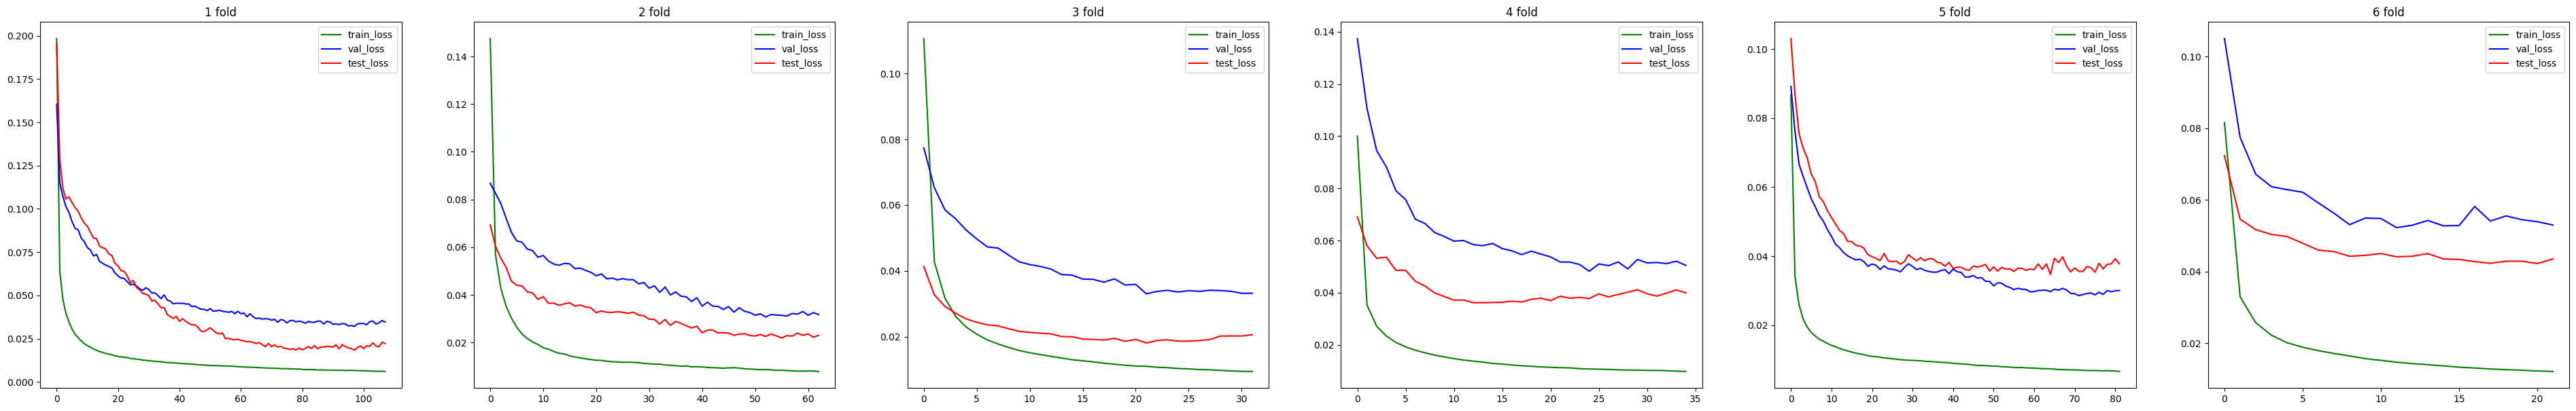

In [11]:
tl.MIMOTSWrapper.plot_losses(*result[:3])

120.2111811009853
Overall loss metrics:
MAE: 114.2065
MSE: 24740.1094
RMSE: 157.2899
MAPE:  2.630%
MPE:  0.436%
 1 hour ahead: MAE:  70.8766,  MSE:  8476.8945, RMSE:  92.0701, MAPE:  1.602%, MPE: -0.036%
 2 hour ahead: MAE: 114.4275,  MSE: 22379.6758, RMSE: 149.5984, MAPE:  2.627%, MPE:  0.389%
 3 hour ahead: MAE: 157.3155,  MSE: 43363.7617, RMSE: 208.2397, MAPE:  3.660%, MPE:  0.956%


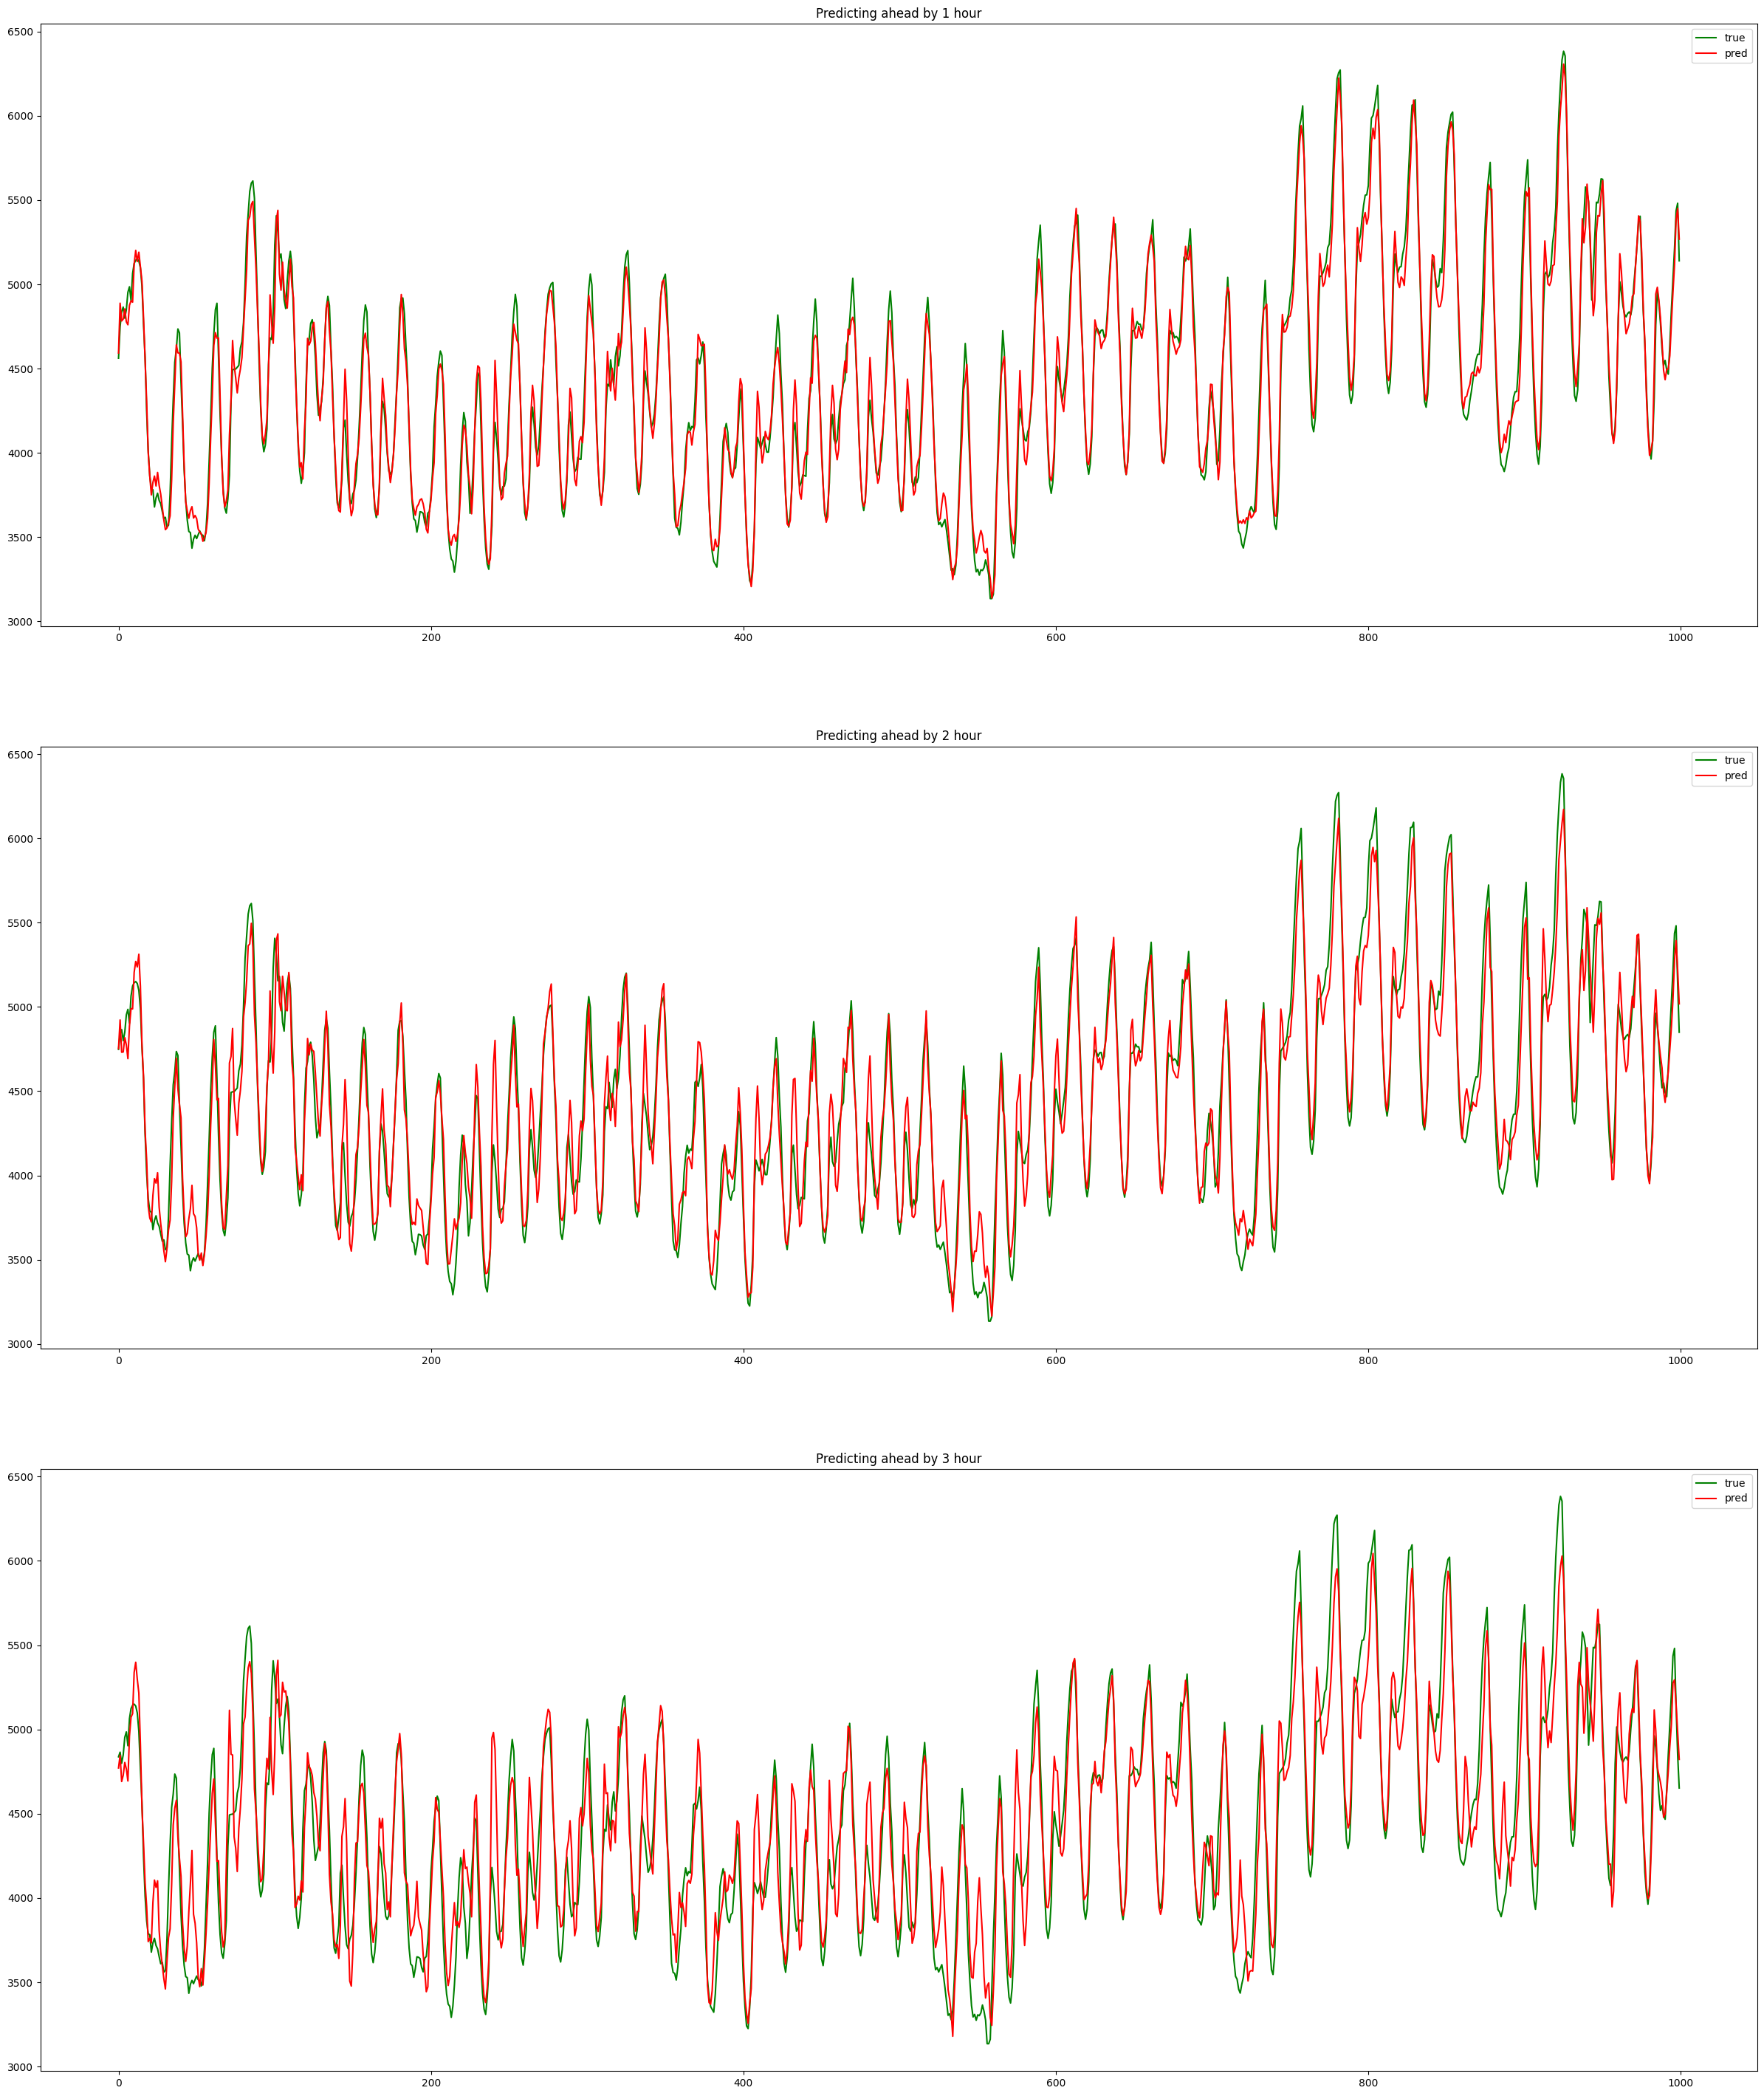

In [26]:
print(sum(result[3]) / len(result[3]))
st = X.shape[0] // 6 // 5
tl.MIMOTSWrapper.print_evaluation_info(*wrapper.predict(X[-st:], y[-st:]))

### Trying a longer sequence length

In [40]:
wrapper = tl.MIMOTSWrapper(ConvNetLong(dropout=0.5, noise=0.1), seq_len=48, pred_len=3)
result = wrapper.validate_ts_strategy(X, y, epochs=200, lr=0.001, n_splits=6, batch_size=64, verbose=4)

[Fold 1] BEGIN
Early stopping... Epoch 066: train loss: 0.005638, val loss: 0.030035, test loss: 0.028254
[Fold 1] END - RMSE loss: 106.538 - Time: 0.7 min.
[Fold 2] BEGIN
Early stopping... Epoch 065: train loss: 0.005523, val loss: 0.020271, test loss: 0.016412
[Fold 2] END - RMSE loss: 87.960 - Time: 1.2 min.
[Fold 3] BEGIN
Early stopping... Epoch 060: train loss: 0.005336, val loss: 0.018665, test loss: 0.016894
[Fold 3] END - RMSE loss: 85.987 - Time: 1.5 min.
[Fold 4] BEGIN
Early stopping... Epoch 043: train loss: 0.006277, val loss: 0.030134, test loss: 0.020918
[Fold 4] END - RMSE loss: 109.342 - Time: 1.4 min.
[Fold 5] BEGIN
Early stopping... Epoch 042: train loss: 0.006496, val loss: 0.030644, test loss: 0.046459
[Fold 5] END - RMSE loss: 148.336 - Time: 1.6 min.
[Fold 6] BEGIN
Early stopping... Epoch 032: train loss: 0.007648, val loss: 0.038135, test loss: 0.040552
[Fold 6] END - RMSE loss: 141.657 - Time: 1.5 min.


113.30323629073371
Overall loss metrics:
MAE: 102.4789
MSE: 20765.3672
RMSE: 144.1019
MAPE:  2.355%
MPE:  0.510%
 1 hour ahead: MAE:  66.7642,  MSE:  8327.5947, RMSE:  91.2557, MAPE:  1.507%, MPE:  0.069%
 2 hour ahead: MAE: 103.0477,  MSE: 19340.3945, RMSE: 139.0697, MAPE:  2.358%, MPE:  0.492%
 3 hour ahead: MAE: 137.6247,  MSE: 34628.1094, RMSE: 186.0863, MAPE:  3.199%, MPE:  0.968%


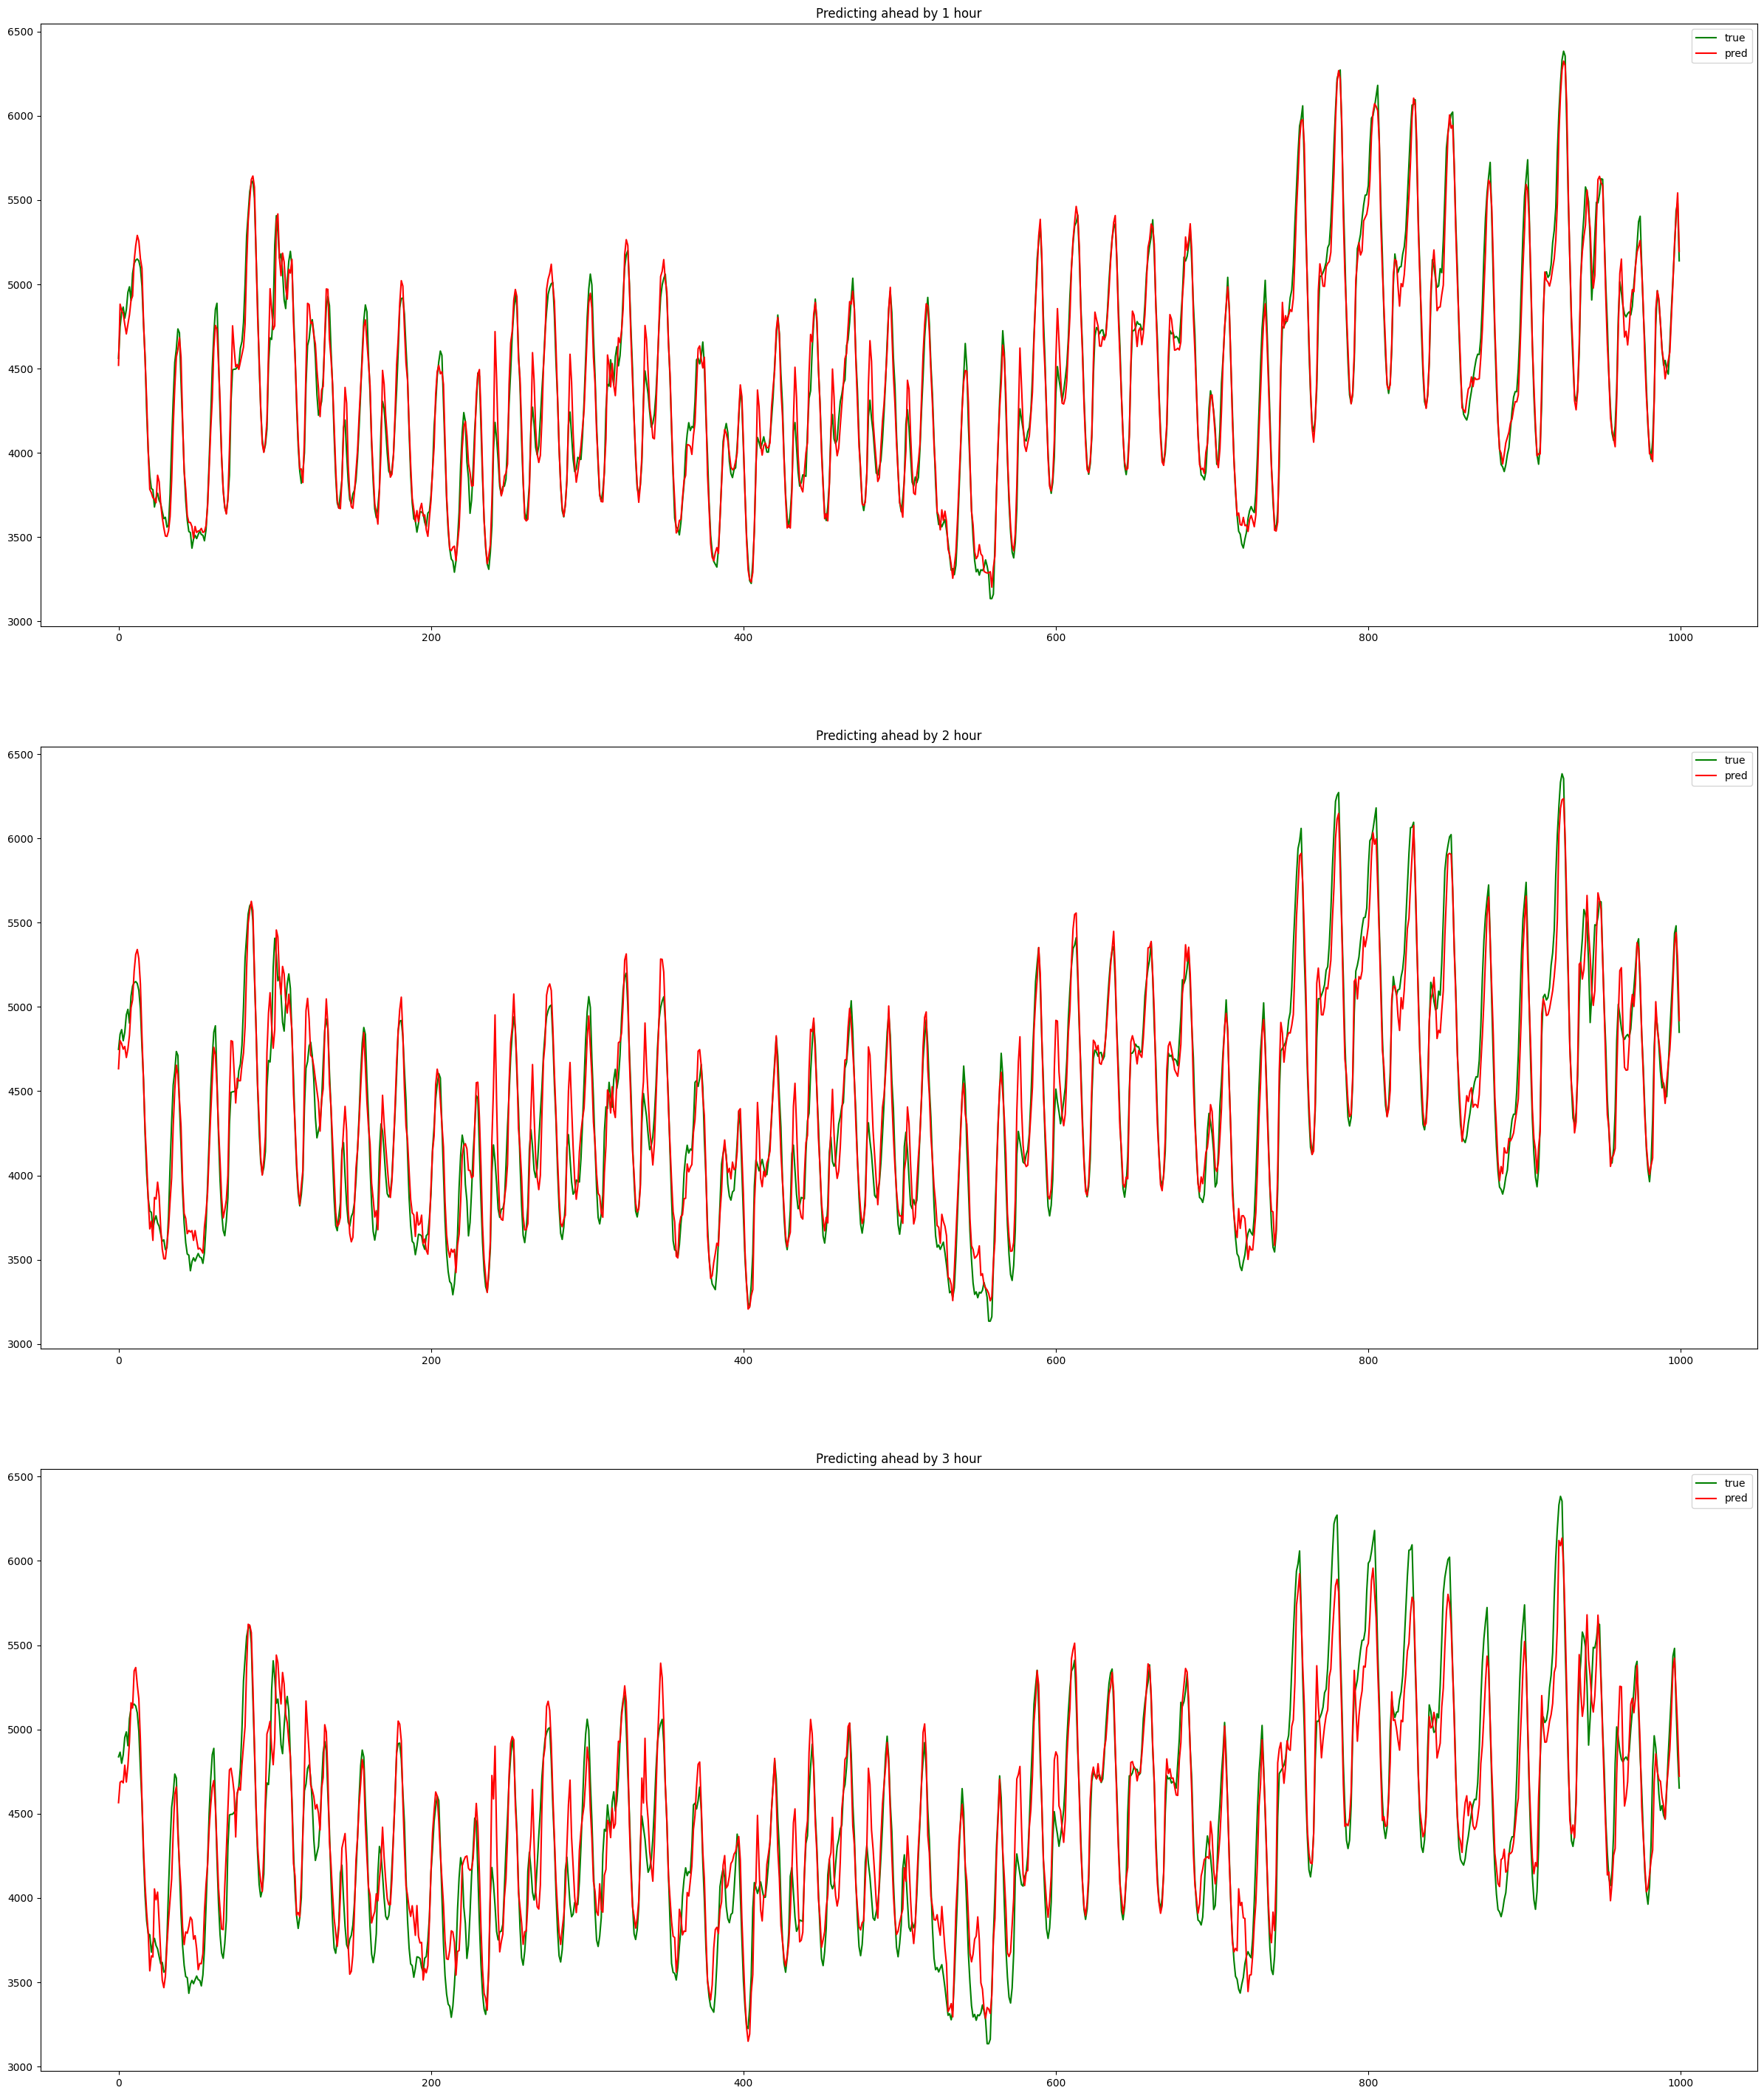

In [43]:
print(sum(result[3]) / len(result[3]))
st = X.shape[0] // 6 // 5
tl.MIMOTSWrapper.print_evaluation_info(*wrapper.predict(X[-st:], y[-st:]))